# Steering Vector Evaluation

## Setup & Mount Drive

In [1]:
!pip install --upgrade bitsandbytes accelerate transformers

In [ ]:
# IMPORTS
from google.colab import drive, userdata
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

# IMPORT LOCAL
from src.steering_benchmarks import benchmark_steering_layers, benchmark_steering_strength
from src.config import MODEL_LIST, STEERING_PROMPT_DIR, EVAL_RESULTS_DIR
from src.visualisation import plot_layer_sweep, plot_strength_heatmap, plot_strength_lines
from src.model_utils import load_model_and_tokenizer


In [3]:
print("--- Notebook Setup ---")

# 1. Mount Google Drive
try:
    drive.mount('/content/drive')
    print("Google Drive mounted.")
except Exception as e:
    print(f"Error mounting drive: {e}")

# 2. Get Project Path from Colab Secrets
try:
    PROJECT_PATH = userdata.get('moral_path')
    if PROJECT_PATH is None: raise ValueError("path secret not found.")
    print(f"PROJECT_PATH set to: {PROJECT_PATH}")
except Exception as e:
    print(f"Error getting secret: {e}")

# Set the HF_TOKEN as an environment variable
HF_TOKEN = userdata.get('HF_TOKEN')
if HF_TOKEN:
    os.environ['HF_TOKEN'] = HF_TOKEN
    print("HF_TOKEN successfully set as environment variable.")
else:
    print("HF_TOKEN secret not found.")

# 3. Add project to Python path and change directory
if 'PROJECT_PATH' in locals() and os.path.exists(PROJECT_PATH):
    if PROJECT_PATH not in sys.path:
        sys.path.append(PROJECT_PATH)
        print(f"Added {PROJECT_PATH} to sys.path")
    os.chdir(PROJECT_PATH)
    print(f"Changed current working directory to: {os.getcwd()}")
else:
    print("PROJECT_PATH not valid. Cannot set up environment.")

--- Notebook Setup ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted.
PROJECT_PATH set to: /content/drive/MyDrive/_PhD/Moral-Reasoning/Experiments/LLM-Moral-Steering/
HF_TOKEN successfully set as environment variable.
Added /content/drive/MyDrive/_PhD/Moral-Reasoning/Experiments/LLM-Moral-Steering/ to sys.path
Changed current working directory to: /content/drive/MyDrive/_PhD/Moral-Reasoning/Experiments/LLM-Moral-Steering


## Eval Setup

In [ ]:
# Configuration
# Select Model
MODEL_TO_USE = MODEL_LIST[0] # Llama 3.1 8B

# Select the Vector File created in vector_generation.ipynb
# TODO add as varaible in notebook premable
VECTOR_FILENAME = f"{MODEL_TO_USE.split('/')[-1]}_layers_16-30_vectors.pt"

# Define the range of layers to check
LAYERS_TO_CHECK = list(range(16, 30))

# Sample Size- keep small for inital benchmarking
SAMPLE_SIZE = 50

## Run Benchmark

Ruuning Benchmark on Activation Addition
Model: meta-llama/Llama-3.1-8B-Instruct
Vectors: Llama-3.1-8B-Instruct_layers_16-30_vectors.pt
Testing Layers: [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
--- Starting Steering Layer Benchmark for meta-llama/Llama-3.1-8B-Instruct ---
Vector File: Llama-3.1-8B-Instruct_layers_16-30_vectors.pt

[+] Loading model: meta-llama/Llama-3.1-8B-Instruct...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

[+] Model loaded successfully in 28.42 seconds.


Testing Layers:   0%|          | 0/14 [00:00<?, ?it/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


   ...Steering active (Layer 16, Multiplier 1.0). Testing 50 pairs...
   ...Steering active (Layer 16, Multiplier -1.0). Testing 50 pairs...

[Layer 16] Results:
+1.0 (Push Deon): 50.0% Deon (Inv: 0.0%)
-1.0 (Push Util): 48.0% Deon (Inv: 0.0%)
   ...Steering active (Layer 17, Multiplier 1.0). Testing 50 pairs...
   ...Steering active (Layer 17, Multiplier -1.0). Testing 50 pairs...

[Layer 17] Results:
+1.0 (Push Deon): 54.0% Deon (Inv: 0.0%)
-1.0 (Push Util): 42.0% Deon (Inv: 0.0%)
   ...Steering active (Layer 18, Multiplier 1.0). Testing 50 pairs...
   ...Steering active (Layer 18, Multiplier -1.0). Testing 50 pairs...

[Layer 18] Results:
+1.0 (Push Deon): 44.0% Deon (Inv: 0.0%)
-1.0 (Push Util): 36.0% Deon (Inv: 0.0%)
   ...Steering active (Layer 19, Multiplier 1.0). Testing 50 pairs...
   ...Steering active (Layer 19, Multiplier -1.0). Testing 50 pairs...

[Layer 19] Results:
+1.0 (Push Deon): 54.0% Deon (Inv: 0.0%)
-1.0 (Push Util): 50.0% Deon (Inv: 0.0%)
   ...Steering active (L

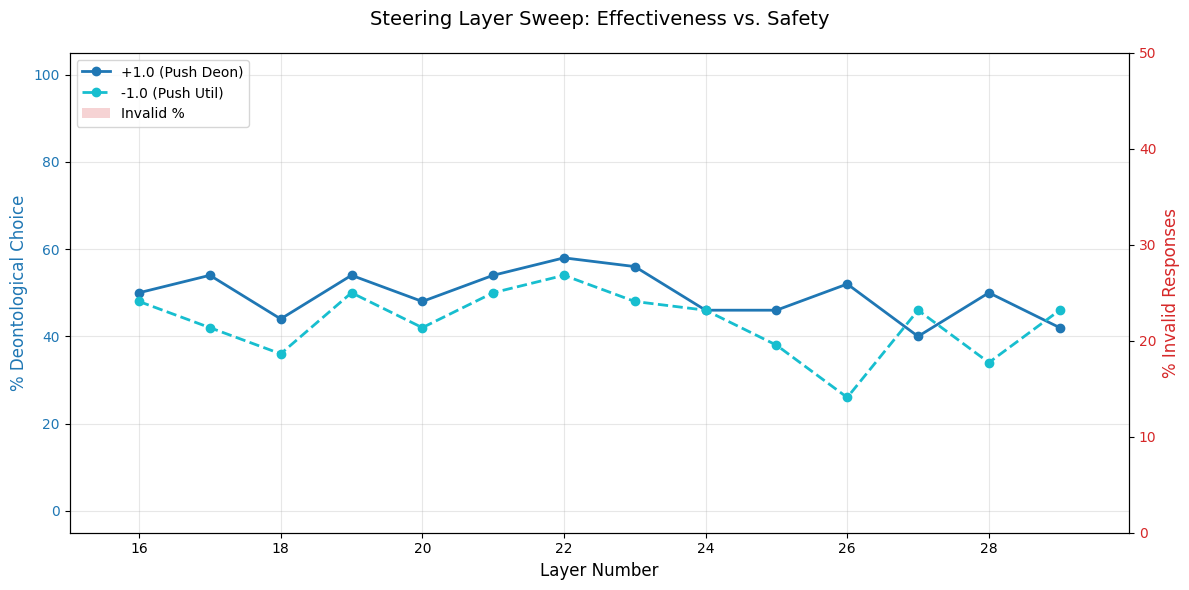

In [5]:
print(f"Ruuning Benchmark on Activation Addition")
print(f"Model: {MODEL_TO_USE}")
print(f"Vectors: {VECTOR_FILENAME}")
print(f"Testing Layers: {LAYERS_TO_CHECK}")

results = benchmark_steering_layers(
    model_id=MODEL_TO_USE,
    vector_filename=VECTOR_FILENAME,
    layers_to_test=LAYERS_TO_CHECK,
    sample_size=SAMPLE_SIZE
)

# save results
# Convert the results list to a DataFrame
df_results = pd.DataFrame(results)

# Define path (e.g., data/evaluation_results/layer_sweep_log.csv)
log_path = EVAL_RESULTS_DIR / "layer_sweep_log.csv"

# Save
df_results.to_csv(log_path, index=False)
print(f"Log file saved to: {log_path}")

# plot the results
plot_layer_sweep(results)

## Test Multiplyer

In [ ]:
# 1. Configuration
# Pick your top 3-4 contenders from the Sanity Check
TARGET_LAYERS = [20, 21, 22, 23, 24, 25, 26, 27, 28]
# We test a range of strengths:
# 0.0 (Baseline), 1.0 (Current), up to 3.0 (Strong push)
STRENGTHS = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

print(f"   Starting Strength Sweep")
print(f"   Layers: {TARGET_LAYERS}")
print(f"   Strengths: {STRENGTHS}")

# 2. Load Model & Tokenizer
# This ensures the code runs even if we skipped previous cells
if 'model' not in locals() or 'tokenizer' not in locals():
    print("\nLoading model for strength sweep...")
    model, tokenizer = load_model_and_tokenizer(MODEL_TO_USE)
else:
    print("\nModel already loaded in memory.")


# --- Phase 3: Fine-Tuning (Multi-Layer Strength Sweep) ---

# 1. Imports
import pandas as pd
import matplotlib.pyplot as plt
from src.model_utils import load_model_and_tokenizer
from src.config import STEERING_PROMPT_DIR, MODEL_LIST
from src.steering_benchmarks import benchmark_steering_strength
from src.visualisation import plot_strength_heatmap, plot_strength_lines

# 2. Configuration
# We define the model again here to be safe, or use the global one
MODEL_TO_USE = MODEL_LIST[0] 
VECTOR_FILENAME = f"{MODEL_TO_USE.split('/')[-1]}_layers_16-30_vectors.pt"

# Pick your top contenders from the Sanity Check results
TARGET_LAYERS = [23, 24, 25, 26] 
STRENGTHS = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

print(f"🚀 Starting Strength Sweep")
print(f"   Layers: {TARGET_LAYERS}")
print(f"   Strengths: {STRENGTHS}")

# 3. Load Model & Tokenizer (The Safety Check)
#    This ensures the code runs even if you skipped previous cells
if 'model' not in locals() or 'tokenizer' not in locals():
    print("\nLoading model for strength sweep...")
    model, tokenizer = load_model_and_tokenizer(MODEL_TO_USE)
else:
    print("\nModel already loaded in memory.")

# 3. Run Benchmark
df_strength = benchmark_steering_strength(
    model=model,
    tokenizer=tokenizer,
    vector_file_path=STEERING_PROMPT_DIR / VECTOR_FILENAME,
    layers_to_test=TARGET_LAYERS,
    multipliers_to_test=STRENGTHS
)

# 5. Visualise
print("\n--- Raw Data Table ---")
display(df_strength)

print("\n--- Visualisation 1: Heatmap ---")
plot_strength_heatmap(df_strength)

print("\n--- Visualisation 2: Response Curves ---")
plot_strength_lines(df_strength)

## Load for Later

In [ ]:
# Reload the data from the CSV
df_strength = pd.read_csv(EVAL_RESULTS_DIR / "strength_sweep_results.csv")

# plot again
plot_strength_lines(df_strength)